Create bdf input and set case control commands.

In [1]:
from pyNastran.bdf.bdf import BDF

# Create BDF object
ucrm9_bdf_input = BDF(debug=None)
# Create case control deck
ucrm9_bdf_input.create_subcases(0)
ucrm9_bdf_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request no Bulk Data to be printed
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('STRAIN', 'ALL', ['PLOT'])  # store strain data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('STRESSES', 'ALL', ['PLOT'])  # store stress data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector
constraint_set_id = 1
ucrm9_bdf_input.case_control_deck.subcases[0].add_integer_type('SPC', constraint_set_id)

subcase=0 already exists...skipping


Create PARAM cards.

In [2]:
ucrm9_bdf_input.add_param('AUTOSPC', ['NO'])  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf_input.add_param('GRDPNT', [1])  # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf_input.add_param('K6ROT', [1e5])  # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf_input.add_param('COUPMASS', [-1])  # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the following elements: CBAR, CBEAM, CONROD, CQUAD4, CHEXA, CPENTA, CPYRAM, CQUAD8, CROD, CTETRA, CTRIA3, CTRlA6, CTRIAX6, CTUBE
ucrm9_bdf_input.add_param('MAXRATIO', [1e7])  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf_input.add_param('POST', [1])  # store results in a op2 file
ucrm9_bdf_input.add_param('POST', [1.])  # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM       POST      1.

Include structural model and 1g aerodynamic load.

In [3]:
import os

ucrm9_bdf_input.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_wingbox_coarse.bdf'))
ucrm9_bdf_input.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_aero_forces_1.0g_coarse.bdf'))

Run linear buckling analysis.

In [4]:
from resources import pynastran_utils

force_set_id = 1
analysis_directory_name = '15_Nonlinear_Buckling_Analysis_of_uCRM-9'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'uCRM9_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=ucrm9_bdf_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

Nastran job uCRM9_linear_buckling.bdf completed
Wall time: 17.0 s


Display buckling factor and plot buckling mode.

Buckling factor: 2.9


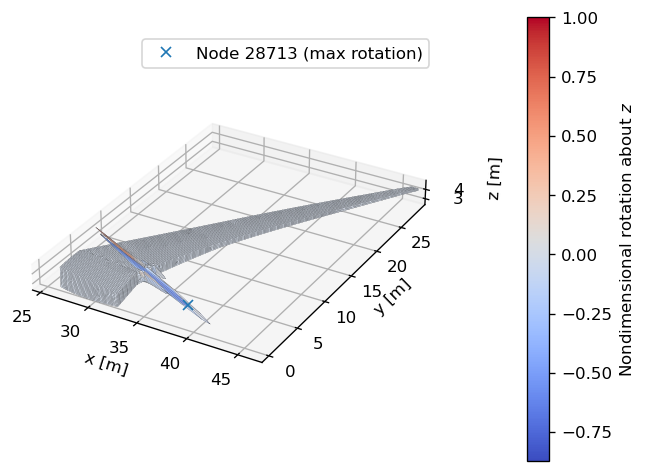

In [5]:
import matplotlib.pyplot as plt  # plotting libary
import numpy as np

# Find critical buckling factor and print it
eigenvalue_calculation_subcase_id = 2
sol_105_buckling_factor = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling factor: {sol_105_buckling_factor:.1f}')

# Find overall critical buckling load magnitude
static_load_subcase_id = 1
applied_load_magnitude = np.linalg.norm(np.apply_along_axis(np.sum, 1, sol_105_op2.load_vectors[static_load_subcase_id].data[:, :, 0:3]))
sol_105_buckling_load_magnitude = applied_load_magnitude*sol_105_buckling_factor

# Plot buckling mode
plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='rz', colormap='coolwarm', displacement_unit='m')
ax.locator_params(axis='z', nbins=1)  # set number of ticks of z-axis

# Plot max rotation node
max_rotation_index = np.argmax(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 5])
max_rotation_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[max_rotation_index, 0]
max_rotation_node_xyz = sol_105_op2.nodes[max_rotation_node_id].xyz + 200*sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, max_rotation_index, 0:3]
ax.plot(max_rotation_node_xyz[0], max_rotation_node_xyz[1], max_rotation_node_xyz[2], 'x', label=f'Node {max_rotation_node_id:d} (max rotation)', zorder=4)
ax.legend()

# Show plot
plt.show()

Set applied load to twice the critical buckling load predicted by SOL 105 and set up a nonlinear analysis witht the arc-length method.

In [6]:
load_scale_factor = 2
load_set_id = force_set_id + 1  # define id of load set
ucrm9_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*load_scale_factor], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
pynastran_utils.set_up_arc_length_method(ucrm9_bdf_input)  # set up SOL 106 with arc-length method using default parameters

Add option to change all CQUADR cards into CQUAD4 cards.

In [7]:
ucrm9_bdf_input.system_command_lines[0:0] = ['NASTRAN QRMETH=3']

Define function to run analysis and plot load-displacement diagram on already defined axes.

In [8]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

tip_node_id = 11847
displacement_component_index = 2
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def plot_load_displacement_diagram(bdf_input, filename, axes, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    step, _, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], step[1]*load_scale_factor, marker=marker_style, linestyle='-', label=line_label)

Investigate effect of error function.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 411.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 410.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 423.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 393.0 s


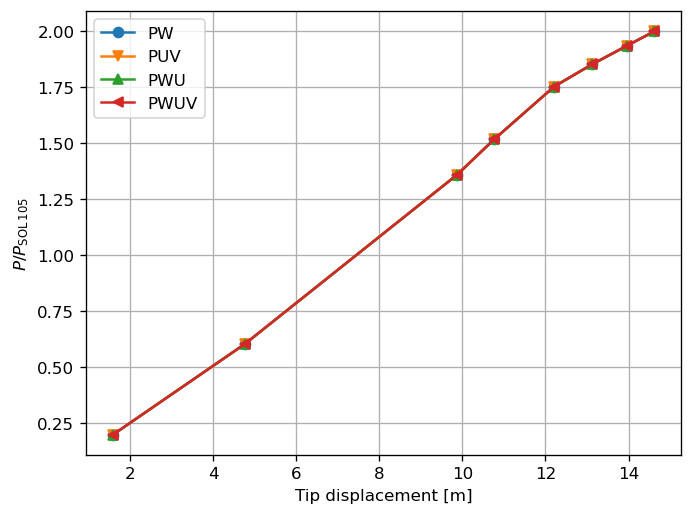

In [9]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

nlparm_id = next(iter(ucrm9_bdf_input.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    ucrm9_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'{fun}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Restore default error function.

In [10]:
ucrm9_bdf_input.nlparms[nlparm_id].conv = 'PW'

Investigate effect of error tolerances.

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 922.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 373.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 455.0 s


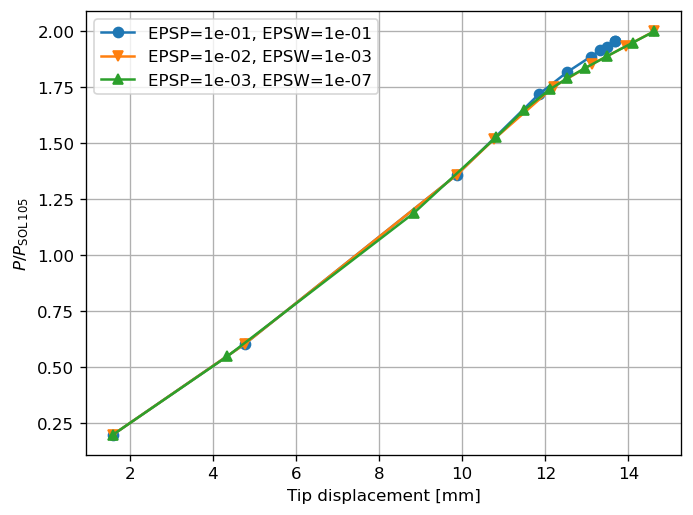

In [11]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    ucrm9_bdf_input.nlparms[nlparm_id].eps_p = epsp
    ucrm9_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [12]:
ucrm9_bdf_input.nlparms[nlparm_id].eps_p = 1e-1
ucrm9_bdf_input.nlparms[nlparm_id].eps_w = 1e-1

In [13]:
# Change load of first subcase
load_scale_factor = 1.9
ucrm9_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_factor*load_scale_factor

# Define load set with no applied force
zero_load_set_id = load_set_id+1
ucrm9_bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])

# Create second subcase
unloading_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=ucrm9_bdf_input, nlparm_id=unloading_subcase_id, eps_p=1e-1, eps_w=1e-1, ninc=100, desiter=5, minalr=1e-2, maxalr=1.01, maxinc=250, subcase_id=unloading_subcase_id)

In [14]:
input_filename = 'bifurcation_verification_epsp1e-1'
no_eigenvalues = 8
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_epsp1e-1.bdf completed
Wall time: 2237.0 s


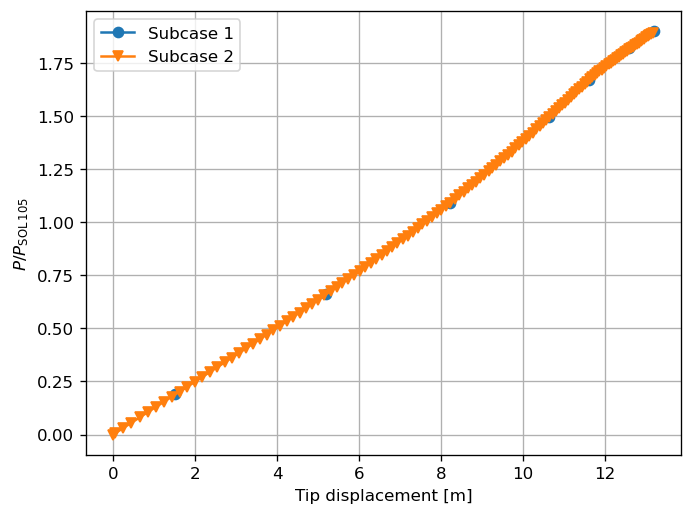

In [15]:
def plot_subcases_load_displacement_diagram(disp, loads):
    # Create figure with one subplot
    _, load_displacement_ax = plt.subplots()
    # Plot the load-displacement diagram for each subcase
    for subcase_id in disp:
        load_displacement_ax.plot(disp[subcase_id][:, displacement_component_index], np.apply_along_axis(np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude, marker=markers[subcase_id - 1], label=f'Subcase {subcase_id:.0f}')
    # Set plot appearance
    load_displacement_ax.legend()
    plt.xlabel('Tip displacement [m]')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements, applied_loads)

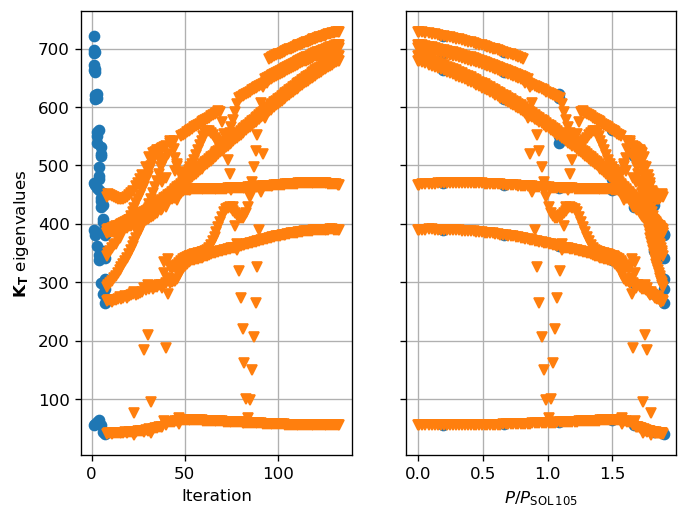

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, filename, loads):
    # Read eigenvalues
    f06_path = os.path.join(directory_path, filename + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase_id in loads:
        no_load_steps = len(loads[subcase_id])
        eigenvalues_by_subcase[subcase_id] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase_id].shape[1] + iterations_count), eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1], label=f'Subcase {subcase_id:d}')
        iterations_count += eigenvalues_by_subcase[subcase_id].shape[1]
        # Plot eigenvalues vs applied load
        eigvals_axs[1].plot(np.apply_along_axis(np.linalg.norm, 1, loads[subcase_id])/sol_105_buckling_load_magnitude, eigenvalues_by_subcase[subcase_id].T, markers[subcase_id - 1], color=colors[subcase_id - 1])
    # Set plot appearance
    # axs[0].legend()
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

1. Aero load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [17]:
for nl_id in range(1, 3):
    ucrm9_bdf_input.nlparms[nl_id].eps_p = 1e-3
    ucrm9_bdf_input.nlparms[nl_id].eps_w = 1e-7

In [18]:
input_filename = 'bifurcation_verification_epsp1e-3'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_epsp1e-3.bdf completed
Wall time: 1546.0 s


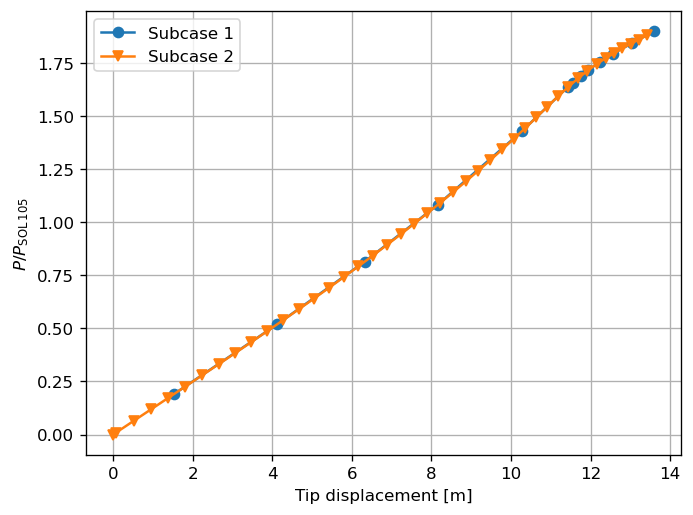

In [19]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements, applied_loads)

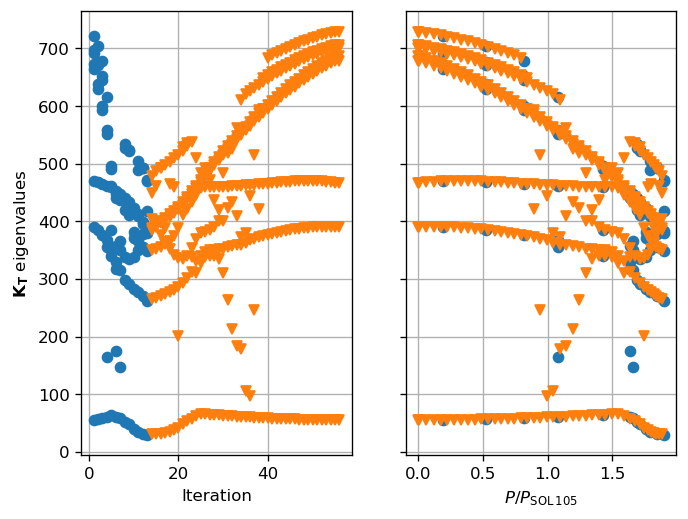

In [20]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Delete second subcase and set convergence tolerances.

In [21]:
del ucrm9_bdf_input.subcases[unloading_subcase_id]
for nl_id in range(1, 3):
    ucrm9_bdf_input.nlparms[nl_id].eps_p = 1e-1
    ucrm9_bdf_input.nlparms[nl_id].eps_w = 1e-1

Investigate effect of initial load increment.

Nastran job nonlinear_analysis_initial_load_increment_0_50.bdf completed
Wall time: 519.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_10.bdf completed
Wall time: 1651.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_01.bdf completed
Wall time: 1522.0 s


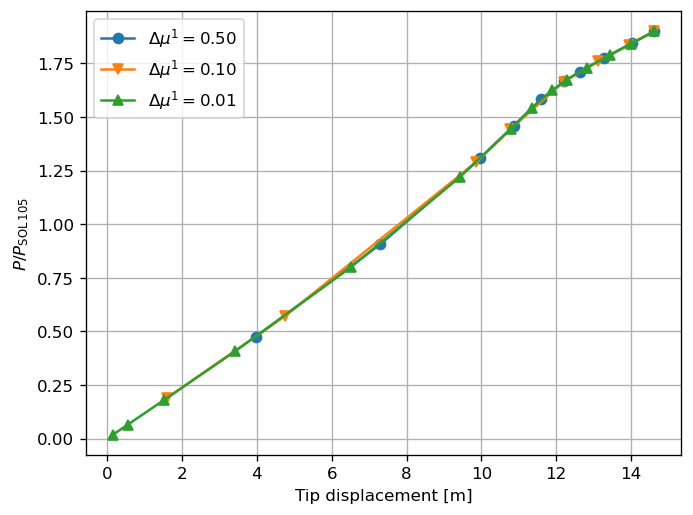

In [22]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    ucrm9_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Investigate effect of number of desired iterations.

In [23]:
ucrm9_bdf_input.nlparms[nlparm_id].ninc = 2

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 189.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 204.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 159.0 s


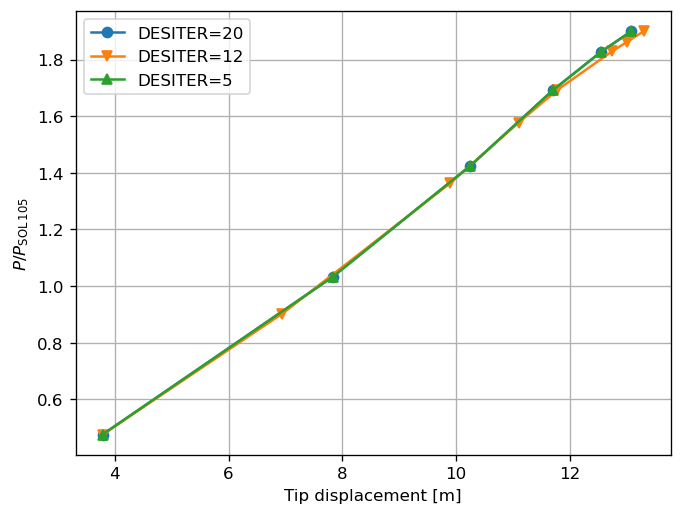

In [24]:
no_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_iterations):
    ucrm9_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = f'nonlinear_analysis_desiter_{desiter:.0f}'
    plot_load_displacement_diagram(ucrm9_bdf_input, input_filename, ax, markers[count], f'DESITER={desiter}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.5, DESITER=20, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [25]:
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id, nlparm_id=unloading_subcase_id)  # create second subcase
ucrm9_bdf_input.nlpcis[nlparm_id].desiter = 20  # set number of desired iterations in first subcase

Nastran job bifurcation_verification_desiter20.bdf completed
Wall time: 1157.0 s


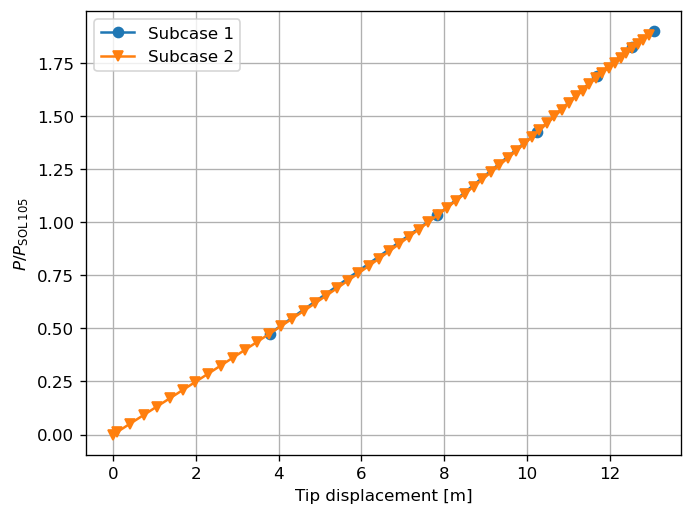

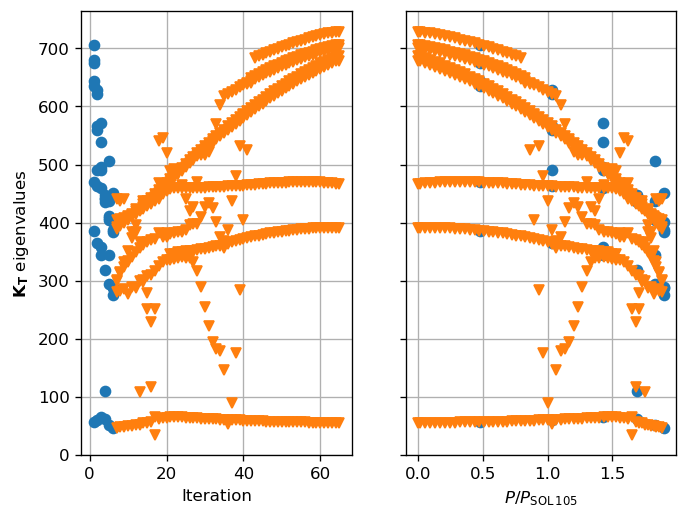

In [26]:
input_filename = 'bifurcation_verification_desiter20'
op2_output_desiter20 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)
_, applied_loads_desiter20, tip_displacements_desiter20 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_desiter20, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements_desiter20, applied_loads_desiter20)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_desiter20)

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.5, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

Nastran job bifurcation_verification_desiter12.bdf completed
Wall time: 1107.0 s


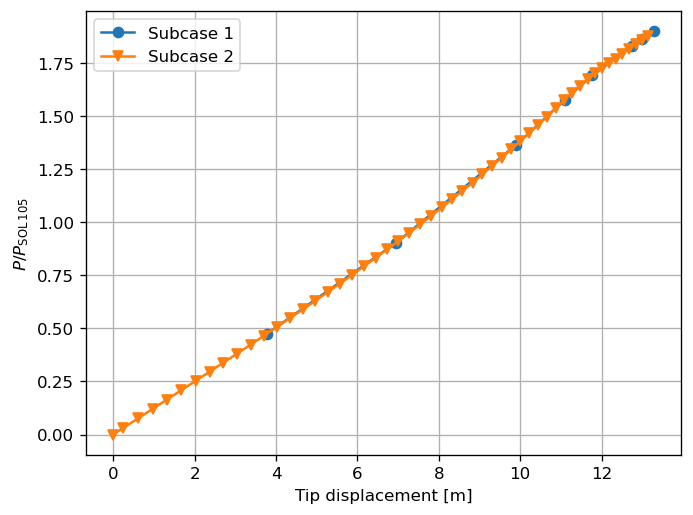

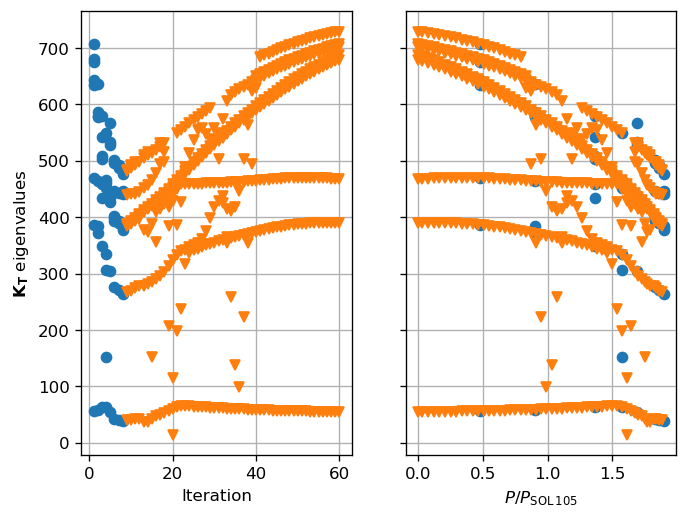

In [27]:
ucrm9_bdf_input.nlpcis[nlparm_id].desiter = 12  # set number of desired iterations in first subcase
input_filename = 'bifurcation_verification_desiter12'
op2_output_desiter12 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)
_, applied_loads_desiter12, tip_displacements_desiter12 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_desiter12, displacement_node_id=tip_node_id)
plot_subcases_load_displacement_diagram(tip_displacements_desiter12, applied_loads_desiter12)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_desiter12)

Natural path.

In [28]:
# Change load of first subcase
load_scale_factor = 2
ucrm9_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_factor*load_scale_factor

# Set nonlinear analysis parameters
ucrm9_bdf_input.nlparms[unloading_subcase_id].eps_p = 1e-3
ucrm9_bdf_input.nlparms[unloading_subcase_id].eps_w = 1e-7
ucrm9_bdf_input.subcases[0].params['NLPARM'][0] = unloading_subcase_id

# Delete second subcase
del ucrm9_bdf_input.subcases[unloading_subcase_id]

In [29]:
input_filename = 'bifurcation_verification_natural_path'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=True)

Nastran job bifurcation_verification_natural_path.bdf completed
Wall time: 1853.0 s


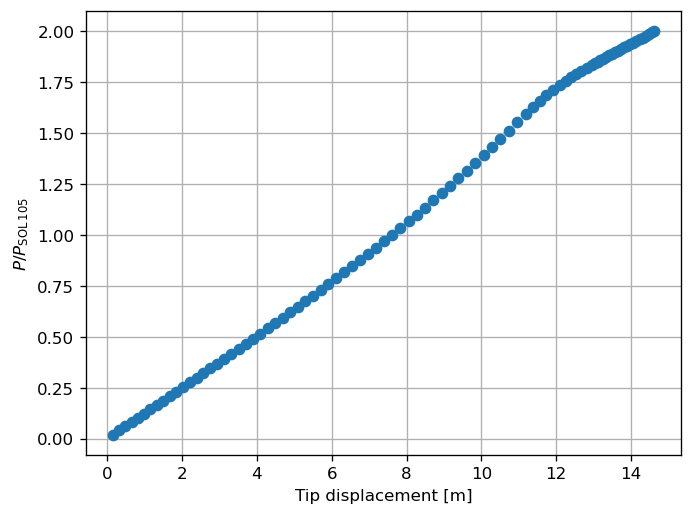

In [30]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_node_id)
applied_load_magnitude_history = np.apply_along_axis(np.linalg.norm, 1, applied_loads[1])

_, load_displacement_ax = plt.subplots()
load_displacement_ax.plot(tip_displacements[1][:, displacement_component_index], applied_load_magnitude_history/sol_105_buckling_load_magnitude, markers[0])
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

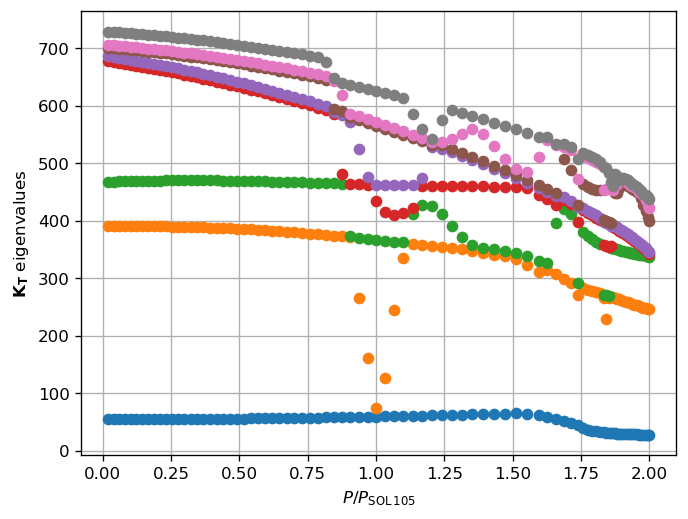

In [31]:
# Read eigenvalues of tangent stiffness matrix
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Plot lowest eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_load_magnitude_history/sol_105_buckling_load_magnitude, eigenvalues.T, markers[0])
ax.set_xlabel('$P/P_\mathrm{SOL\/105}$')
ax.set_ylabel('$\mathbf{K_T}$ eigenvalues')
ax.grid(visible=True)
plt.show()